# Always Run

In [103]:
from IPython.display import display, Math
from scipy.fft import fft, ifft
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit

def compute_modified_input(ideal_waveform, distorted_waveform):
    # Perform FFT on both waveforms
    ideal_fft = np.fft.fft(ideal_waveform)
    distorted_fft = np.fft.fft(distorted_waveform)
    
    # Estimate the transfer function H(f)
    # Avoid division by zero by adding a small epsilon where necessary
    H = distorted_fft / (ideal_fft + epsilon)
    # Compute the inverse transfer function
    H_inv = 1 / (H + epsilon)
    # Apply the inverse filter to the ideal waveform in the frequency domain
    modified_fft = ideal_fft * H_inv
    
    #can add a high pass filter
    # modified_fft[800:] = 0 
    
    # Get the modified input signal by inverse FFT
    modified_waveform = np.fft.ifft(modified_fft)
    
    # Return the real part of the modified waveform and the estimated transfer function
    return np.real(modified_waveform), H

def compute_expected_output(modified_input, H):
    # Perform FFT on the modified input
    modified_fft = np.fft.fft(modified_input)
    # Apply the transfer function H(f) to the modified input in frequency domain
    expected_output_fft = modified_fft * (H)
    # Get the expected output signal by inverse FFT
    expected_output_waveform = np.fft.ifft(expected_output_fft)
    # Return the real part (just taking cosine constributions -- is still approximately complete
    return np.real(expected_output_waveform)

def truncate_signal(modified_input, min_output, max_output):
    # Can perform a simple truncation of a given numpy array so as to cut off out of range mins/maxes
    modified_input_truncated = np.where(modified_input > max_output, max_output, modified_input)
    modified_input_truncated = np.where(modified_input < min_output, min_output, modified_input_truncated)
    return modified_input_truncated

# Real Icicle Data

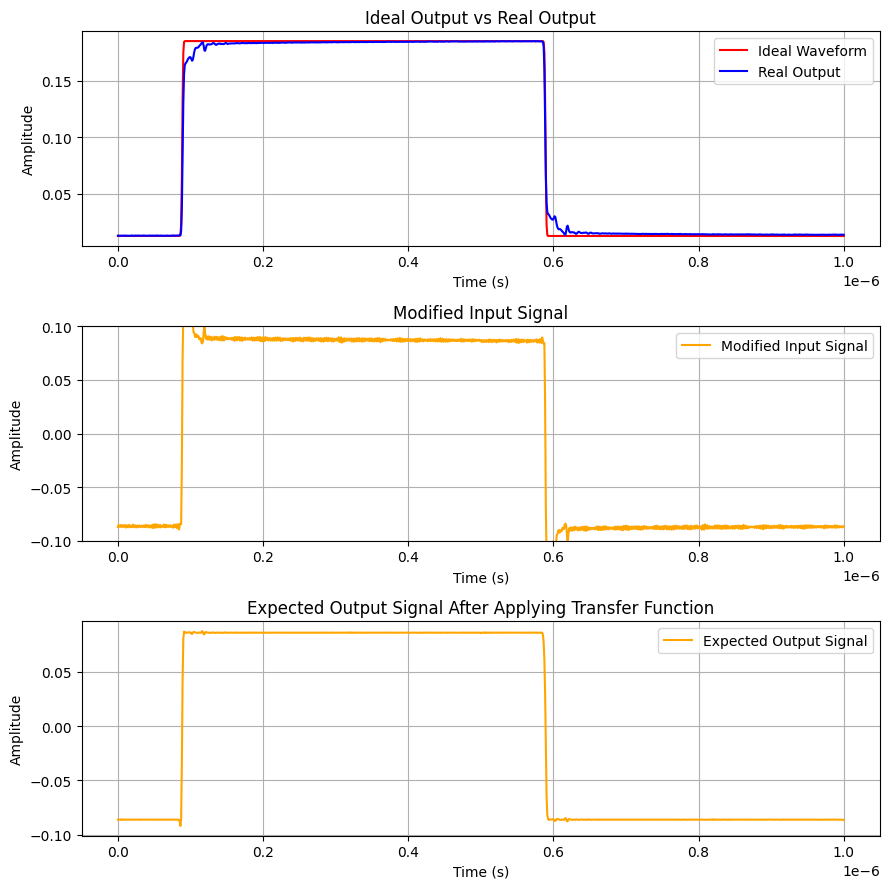

In [2]:
fname = 'Data/A14_120MHzLPF_square_500flat_0rampeachside_1V.csv'
real_output = np.loadtxt(fname, delimiter=',', skiprows=1)
time_array = real_output[:,0]
real_output = real_output[:,1]
#uncomment for no average offset
# real_output = real_output-np.mean(real_output) 

#ideal pulse parameters (empirical)
start_rise_t = 8.898e-8
flat_length = 500e-9
rise_rate = None
max_value = np.max(real_output)
min_value = np.min(real_output)

#formulating ideal pulse
ideal_output = np.zeros(real_output.shape)
boolean_condition = (time_array > start_rise_t) & (time_array < (start_rise_t+flat_length))
ideal_output = np.where(boolean_condition, max_value, min_value)

#required to make the ideal case analytic. Units of sigma is the units of time quantized in sample spacing 
ideal_output = gaussian_filter(ideal_output, sigma=1)

#initializing these arrays so the first column has the times in them
modified_input = np.zeros(real_output.shape)
expected_output = np.zeros(real_output.shape)

# Compute the modified input and the estimated transfer function (H)
epsilon = 1e-4 #a stiffness parameter for the fit. Lower is less strict
modified_input, H = compute_modified_input(ideal_output, real_output)
modified_input = modified_input-np.mean(modified_input) #just removing any DC offset

#uncomment for various filtering on the input to be more physical
# modified_input = truncate_signal(modified_input, -2, 2)
modified_input = gaussian_filter(modified_input, 0.5)

# Compute the expected output signal
expected_output = compute_expected_output(modified_input, H)

#uncomment for various filtering on the output to be more physical
# expected_output = truncate_signal(expected_output, -2, 2)
# expected_output = gaussian_filter(expected_output, 1)

# Plotting for visualization
plt.figure(figsize=(9, 9))
yscale_tuple = (-0.1, 0.1)

# Plot the ideal waveform and the real waveform
plt.subplot(3, 1, 1)
plt.plot(time_array, ideal_output, label='Ideal Waveform', color='r')
plt.plot(time_array, real_output, label='Real Output', color='b')
plt.title('Ideal Output vs Real Output')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# plt.ylim(*yscale_tuple)
plt.grid()
plt.legend()

# Plot the modified input waveform
plt.subplot(3, 1, 2)
plt.plot(time_array, modified_input, label='Modified Input Signal', color='orange')
plt.title('Modified Input Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(*yscale_tuple)
plt.grid()
plt.legend()

# Plot the expected output waveform
plt.subplot(3, 1, 3)
plt.plot(time_array, expected_output, label='Expected Output Signal', color='orange',)
plt.title('Expected Output Signal After Applying Transfer Function')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# plt.ylim(*yscale_tuple)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Creating Synthetic Test Data
- Transfer Function robustness testing

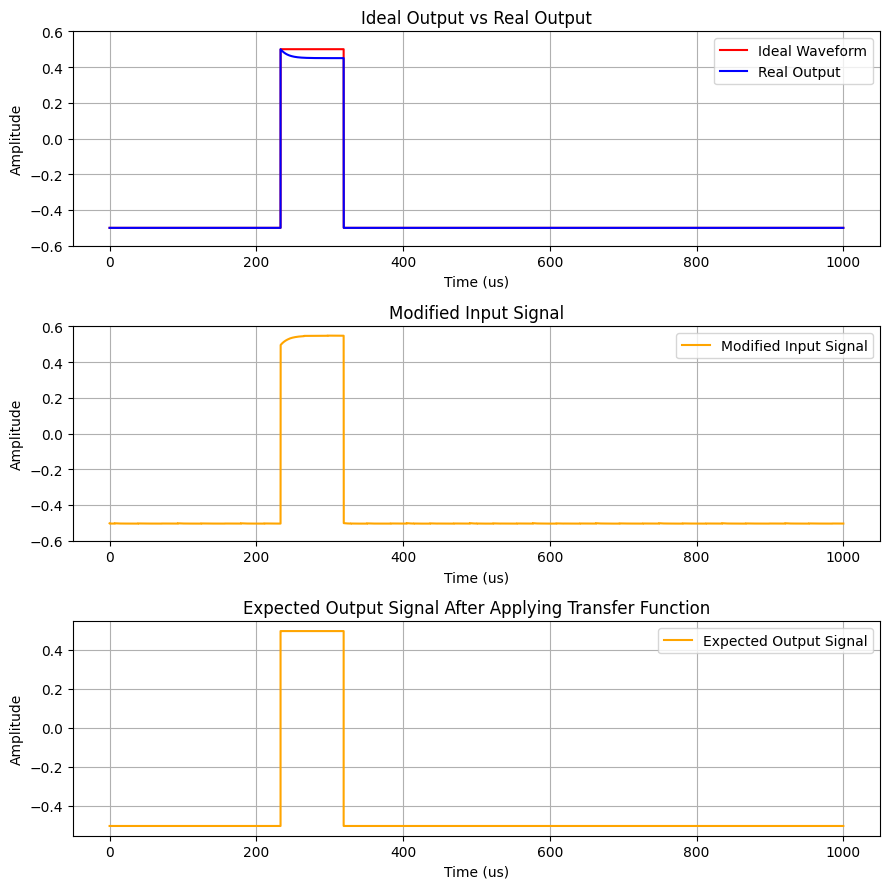

In [3]:
# Creating synthetic data
# Pulse parameters
pulse_length = 1000e-6
start_square = pulse_length*0.233
end_square = pulse_length*0.319
min_amp = -0.5
max_amp = 0.5
sag_amp = max_amp*0.1
samples = 1000000
analyticity = 0

time_array = np.linspace(0, pulse_length, samples)
square_boolean = (time_array > start_square) & (time_array < end_square)
pulse = np.empty(samples)
pulse = np.where(square_boolean, max_amp, min_amp)
pulse = pulse + np.where(square_boolean, (np.exp(-(time_array-start_square)*1e5)-1)*sag_amp, 0)
pulse = gaussian_filter(pulse, sigma=analyticity) #adding some realism (analytic now)

#constructing ideal pulse
ideal_sagging_pulse = np.empty(samples)
ideal_sagging_pulse = np.where(square_boolean, max_amp, min_amp)
ideal_sagging_pulse = gaussian_filter(ideal_sagging_pulse, sigma=analyticity)

real_output = np.copy(pulse)
ideal_output = np.copy(ideal_sagging_pulse)

modified_input = np.zeros(real_output.shape)
expected_output = np.zeros(real_output.shape)

ideal_output = np.copy(ideal_sagging_pulse)
real_output = np.copy(pulse)

# Compute the modified input and the estimated transfer function (H)
epsilon = 1e-3 #a stiffness parameter for the fit. Lower is less strict
modified_input, H = compute_modified_input(ideal_output, real_output)
mean_dc_offset = np.mean(ideal_sagging_pulse)-np.mean(modified_input)
modified_input = modified_input+(mean_dc_offset) #just removing any DC offset

#uncomment for various filtering on the input to be more physical
# modified_input = truncate_signal(modified_input, -2, 2)
# modified_input = gaussian_filter(modified_input, 30)

# Compute the expected output signal
expected_output = compute_expected_output(modified_input, H)

#uncomment for various filtering on the output to be more physical
# expected_output = truncate_signal(expected_output, -2, 2)
# expected_output = gaussian_filter(expected_output, 1)

# Plotting for visualization
plt.figure(figsize=(9, 9))
yscale_tuple = (-0.6, 0.6)

# Plot the ideal waveform and the real waveform
plt.subplot(3, 1, 1)
plt.plot(time_array*1e6, ideal_output, label='Ideal Waveform', color='r')
plt.plot(time_array*1e6, real_output, label='Real Output', color='b')
plt.title('Ideal Output vs Real Output')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude')
plt.ylim(*yscale_tuple)
plt.grid()
plt.legend()

# Plot the modified input waveform
plt.subplot(3, 1, 2)
plt.plot(time_array*1e6, modified_input, label='Modified Input Signal', color='orange')
plt.title('Modified Input Signal')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude')
plt.ylim(*yscale_tuple)
plt.grid()
plt.legend()

# Plot the expected output waveform
plt.subplot(3, 1, 3)
plt.plot(time_array*1e6, expected_output, label='Expected Output Signal', color='orange',)
plt.title('Expected Output Signal After Applying Transfer Function')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude')
# plt.ylim(*yscale_tuple)
plt.grid()
plt.legend()
plt.tight_layout()

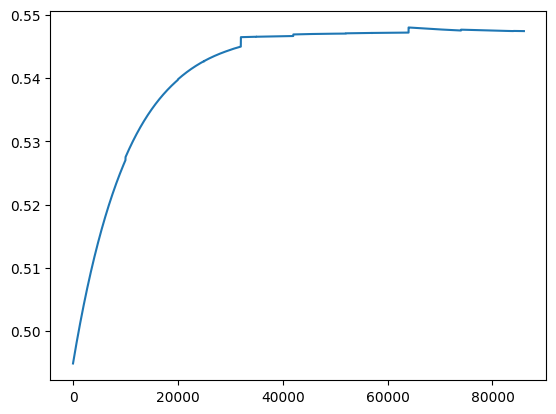

In [4]:
plt.plot(modified_input[int(start_square*samples/pulse_length):int(end_square*samples/pulse_length)])

In [4]:
icicle_real_output = np.asarray([x_values,y_values]).T
np.savetxt('Data/snowflake_real_data.csv', icicle_real_output, delimiter=',')

NameError: name 'x_values' is not defined

# Snowflake Real Data

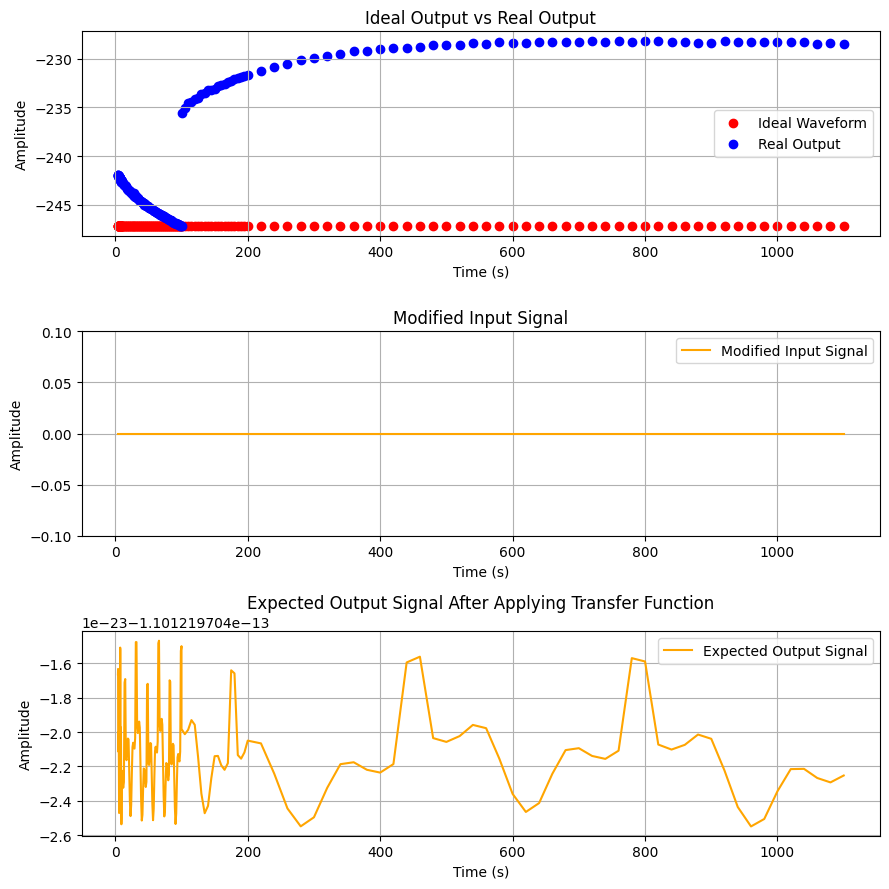

In [14]:
fname = 'Data/snowflake_real_data.csv'
real_data = np.loadtxt(fname, delimiter=',', skiprows=0)

time_array = real_data[:,0]
real_output = real_data[:,1]
#uncomment for no average offset
# real_output = real_output-np.mean(real_output) 

#ideal pulse parameters (empirical)
start_rise_t = 8.898e-8
flat_length = 500e-9
rise_rate = None
max_value = np.max(real_output)
min_value = np.min(real_output)

#formulating ideal pulse
ideal_output = np.zeros(real_output.shape)
boolean_condition = (time_array > start_rise_t) & (time_array < (start_rise_t+flat_length))
ideal_output = np.where(boolean_condition, max_value, min_value)

#required to make the ideal case analytic. Units of sigma is the units of time quantized in sample spacing 
ideal_output = gaussian_filter(ideal_output, sigma=1)

#initializing these arrays so the first column has the times in them
modified_input = np.zeros(real_output.shape)
expected_output = np.zeros(real_output.shape)

# Compute the modified input and the estimated transfer function (H)
epsilon = 1e-4 #a stiffness parameter for the fit. Lower is less strict
modified_input, H = compute_modified_input(ideal_output, real_output)
modified_input = modified_input-np.mean(modified_input) #just removing any DC offset

#uncomment for various filtering on the input to be more physical
# modified_input = truncate_signal(modified_input, -2, 2)
modified_input = gaussian_filter(modified_input, 0.5)

# Compute the expected output signal
expected_output = compute_expected_output(modified_input, H)

#uncomment for various filtering on the output to be more physical
# expected_output = truncate_signal(expected_output, -2, 2)
# expected_output = gaussian_filter(expected_output, 1)

# Plotting for visualization
plt.figure(figsize=(9, 9))
yscale_tuple = (-0.1, 0.1)

# Plot the ideal waveform and the real waveform
plt.subplot(3, 1, 1)
plt.plot(time_array, ideal_output, label='Ideal Waveform', color='r')
plt.plot(time_array, real_output, label='Real Output', color='b')
plt.title('Ideal Output vs Real Output')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# plt.ylim(*yscale_tuple)
plt.grid()
plt.legend()

# Plot the modified input waveform
plt.subplot(3, 1, 2)
plt.plot(time_array, modified_input, label='Modified Input Signal', color='orange')
plt.title('Modified Input Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(*yscale_tuple)
plt.grid()
plt.legend()

# Plot the expected output waveform
plt.subplot(3, 1, 3)
plt.plot(time_array, expected_output, label='Expected Output Signal', color='orange',)
plt.title('Expected Output Signal After Applying Transfer Function')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# plt.ylim(*yscale_tuple)
plt.grid()
plt.legend()

plt.tight_layout()

# Exponential Fittings (Real)

<IPython.core.display.Math object>

[  -6.94322333  138.01248203 -228.22790406]


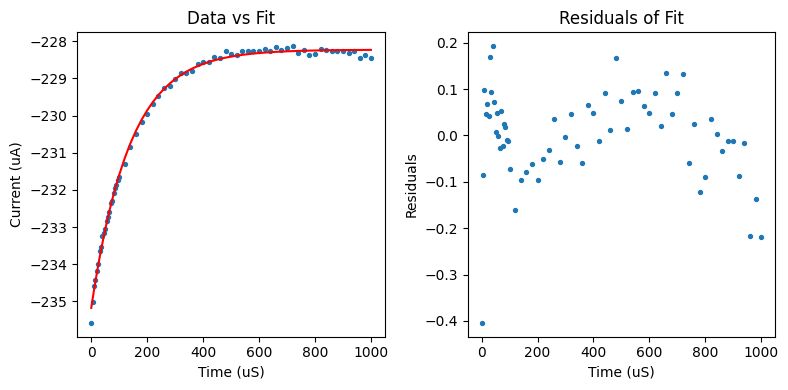

In [140]:
# Sort data if out of time order
if not np.all(time_array[:-1] <= time_array[1:]):
    sorted_indices = np.argsort(time_array)
    time_array = time_array[sorted_indices]
    real_output = real_output[sorted_indices]
    
# Finding Split Point
start_index=0
mid_index=121

# Splitting Sections
sec_1_time = time_array[start_index:mid_index]
sec_1_data = real_output[start_index:mid_index]
sec_2_time = time_array[mid_index:]
sec_2_data = real_output[mid_index:]

# Define Fitting Section
sec_time = sec_2_time
sec_data = sec_2_data

sec_time = sec_time - np.min(sec_time)

# Interpolating
n_points = 300
sec_time_lin = np.linspace(
    start=np.min(sec_time),
    stop=np.max(sec_time),
    num=n_points)
sec_data_interp = np.interp(sec_time_lin, sec_time, sec_data)

# Fit data in (raw data or interpolated data depending on preference)
fit_time_in = sec_time
fit_data_in = sec_data
# fit_time_in = sec_time_lin
# fit_data_in = sec_data_interp

# Fit
def decaying_exp(t, A, tau, C):
    return A*np.exp(-t/tau)+C
p0_sec1 = [7,138,-229]
p0_sec2 = [] # Unset
popt, pcov = curve_fit(decaying_exp, fit_time_in, fit_data_in, p0=p0_sec1)
fit_vals_out = decaying_exp(fit_time_in, *popt) 
residuals = fit_data_in-fit_vals_out

# Plot agreement
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(fit_time_in, fit_data_in, s=8)
ax[0].plot(fit_time_in, fit_vals_out, c='r')
ax[0].set_title('Data vs Fit')
ax[0].set_xlabel('Time (uS)')
ax[0].set_ylabel('Current (uA)')
ax[1].scatter(fit_time_in, residuals, s=8)
ax[1].set_title('Residuals of Fit')
ax[1].set_xlabel('Time (uS)')
ax[1].set_ylabel('Residuals')
fig.tight_layout()

# Nicely formatting data out
latex_eq = rf"y(t) = {popt[0]:.3g} \, e^{{-t/{popt[1]:.3g}}} + {popt[2]:.3g}"
display(Math(latex_eq))
print(popt)

# Findings:

![Section1](Images/Section1.png) ![Section2](Images/Section2.png)

Notice the similar residual pattern shape (though nither seems like a decaying exponential, except perhaps the very beginning of both)

# Exponential Fittings (Synthetic)